<a href="https://colab.research.google.com/github/rajkgurindapalli/rajkgurindapalli/blob/main/Raj_BookRecommendation_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [6]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [26]:
# creating bool series True for NaN values
bool_series = pd.isnull(df_books["title"])
df_books[bool_series]

bool_series = pd.isnull(df_ratings["rating"])
df_ratings[bool_series]

,user,isbn,rating


In [ ]:
# get list of users to remove
user_ratingCount = (df_ratings.
     groupby(by = ['user'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['user', 'totalRatingCount']]
)
users_to_remove = user_ratingCount.query('totalRatingCount > 200').user.tolist()

In [53]:
# merge rating and catalog by bookId
df = pd.merge(df_ratings,df_books,on='isbn')

# create totalRatingCount
book_ratingCount = (df.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
rating_with_totalRatingCount = df.merge(book_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [54]:
# remove books with less than 100 ratings
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount > 100')

# remove from the dataset users with less than 200 ratings 
rating_popular_book = rating_popular_book[rating_popular_book['user'].isin(users_to_remove)]

In [56]:
# pivot table and create matrix
book_features_df = rating_popular_book.pivot_table(index='title',columns='user',values='rating').fillna(0)
book_features_df_matrix = csr_matrix(book_features_df.values)

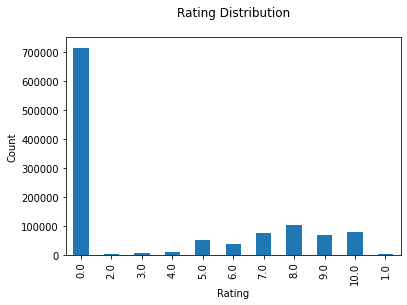

In [38]:
plt.rc("font", size=10)
df_ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [57]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    model_knn = NearestNeighbors(metric = 'cosine', n_neighbors=5, algorithm='auto')
    model_knn.fit(book_features_df_matrix)

    # found book TODO: user a better search
    for query_index in range(len(book_features_df)):
        if book_features_df.index[query_index] == book:
            break

    # creating return structure
    ret = [book_features_df.index[query_index], []]
    distances, indices = model_knn.kneighbors(book_features_df.iloc[query_index,:].values.reshape(1, -1))
    # now we located the book. lets show the recomendations
    for i in range(1, len(distances.flatten())):
        ret[1].insert(0, [book_features_df.index[indices.flatten()[i]], distances.flatten()[i]])
    return ret

In [58]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Weight of Water', 0.77085835], ['I Know This Much Is True', 0.7529293], ['The Lovely Bones: A Novel', 0.7230184], ['Blue Diary', 0.71828747]]]
You passed the challenge! 🎉🎉🎉🎉🎉
